# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.layers import TimeDistributed,Conv2D, MaxPooling2D,LSTM
# from tensorflow.keras.layers.convolutional import 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
import cv2

import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# Intializing the parameters
curr_dt_time = datetime.datetime.now()

path = "/home/datasets/Project_data/"
train_doc = np.random.permutation(open(path + 'train.csv').readlines())
val_doc = np.random.permutation(open(path + 'val.csv').readlines())
#train_path = 'Project_data'+'/'+ 'train'
#val_path =  'Project_data'+'/'+ 'val'

train_path = path + 'train'+'/'
val_path =  path + 'val'+'/'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
batch_size =30 #experiment with the batch size

# training sequences = 663
# validation sequences = 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
class Init_modelBuilder_params():
    
    def init_imageparams(self,image_height=100,image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
        
    def init_hyperparams(self,frames_to_sample=30,batch_size=20,no_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.no_epochs = no_epochs
        
        
    def generator(self,source_path, folder_list):
        #print( 'Source path = ', source_path, '; batch size =', batch_size)
        
        #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
            
            for batch in range(num_batches):
                batch_data, batch_labels = self.generator_extended(source_path,t,batch,batch_size,img_idx)
                yield batch_data, batch_labels
                
            balance_len = len(t)%batch_size
            
            if (balance_len !=0):
                batch_data, batch_labels = self.generator_extended(source_path,t,batch,batch_size,img_idx,balance_len)
                yield batch_data, batch_labels
                
    def generator_extended(self,source_path,t,batch,batch_size,img_idx,balance_len=0):
        
        len_seq = balance_len if (balance_len!=0) else batch_size
        
        batch_data = np.zeros((len_seq,len(img_idx),self.image_height,self.image_width,self.channels))
        # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((len_seq,5))
        # batch_labels is the one hot representation of the output
        
        for folder in range(len_seq): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resize = resize(image,(self.image_height,self.image_width,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image_resize[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resize[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resize[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
        return(batch_data, batch_labels)
    
    def model_train(self, model):
        
        train_generator = self.generator(train_path, train_doc)
        val_generator = self.generator(val_path, val_doc)

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        # write the REducelronplateau code here
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%self.batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1


        temp_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.no_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
        return temp_model

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Plotting Model History 

In [6]:
# function to plot the training/validation accuracies and losses.
import matplotlib.pyplot as plt

def plot_model_history(history):
    with plt.style.context("bmh"):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(history.history['loss'])   
        axes[0].plot(history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(history.history['categorical_accuracy'])   
        axes[1].plot(history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
class Model1(Init_modelBuilder_params):
    
    def model1(self):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the train_generator and the val_generator which will be used in .fit_generator.

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

### Experimenting with Image resolution, number of frames to use and batch_size

Lets see the impact of image resolution, number of frames and batch size on model training time

**Note:** we will train the models for only 2 epocs as we only want to see how above params affect training time

#### Initial Parmas

Parmas: image_height=120, image_width=120, frames_to_sample=30, batch_size=40, no_epochs=2

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 60, 60, 32)    0

2023-10-28 08:39:53.426219: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-28 08:39:53.426285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Epoch 1/2


2023-10-28 08:40:04.017098: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.5904 - categorical_accuracy: 0.4057
Epoch 00001: saving model to model_init_2023-10-2808_39_51.722631/model-00001-1.59035-0.40573-2.15670-0.18000.h5
17/17 [==============================] - 160s 10s/step - loss: 1.5904 - categorical_accuracy: 0.4057 - val_loss: 2.1567 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 0.9729 - categorical_accuracy: 0.6139
Epoch 00002: saving model to model_init_2023-10-2808_39_51.722631/model-00002-0.97293-0.61388-4.07461-0.16000.h5
17/17 [==============================] - 159s 10s/step - loss: 0.9729 - categorical_accuracy: 0.6139 - val_loss: 4.0746 - val_categorical_accuracy: 0.1600 - lr: 0.0010
CPU times: user 7min 1s, sys: 9min 38s, total: 16min 39s
Wall time: 5min 28s


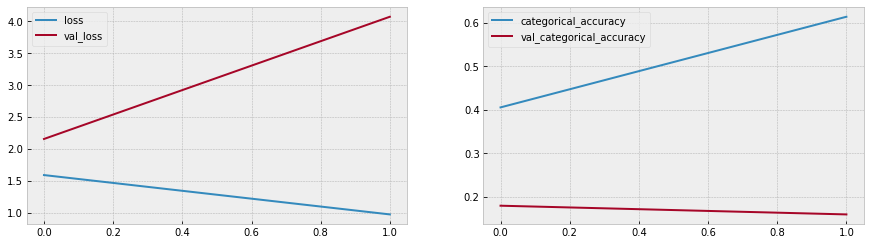

In [8]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=40,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

### Reducing image size

Setting image size to 50 x 50

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 50, 50, 16)    1312      
                                                                 
 activation_4 (Activation)   (None, 30, 50, 50, 16)    0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 50, 50, 16)   64        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 25, 25, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 25, 25, 32)    4128      
                                                                 
 activation_5 (Activation)   (None, 15, 25, 25, 32)   

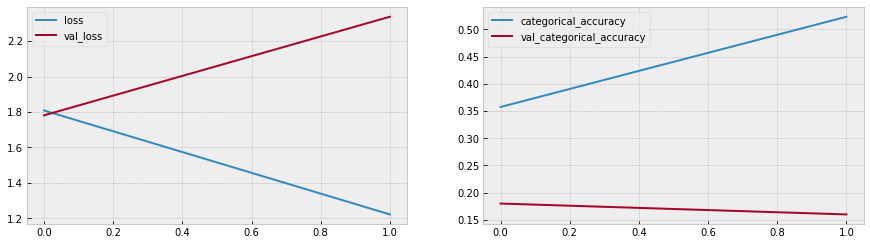

In [9]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=50,image_width=50)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=40,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

### Reducing number of frames

Setting number of frames to 20

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 10, 60, 60, 32)   

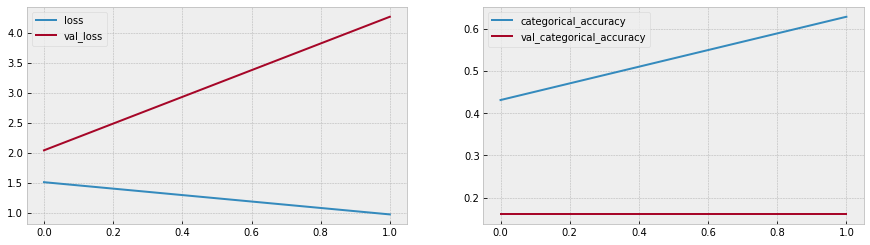

In [10]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=20,batch_size=40,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

### Increasing batch size to 50

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_13 (Activation)  (None, 15, 60, 60, 32)   

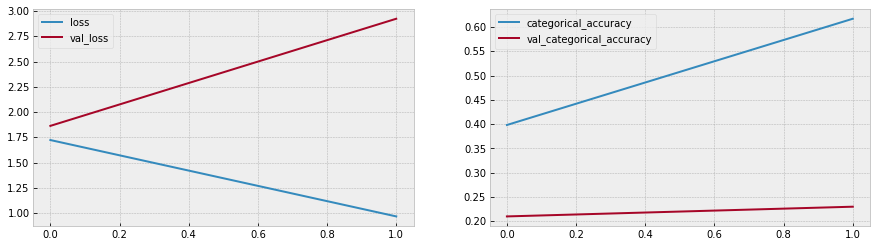

In [11]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=50,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

### Conclusion
- Reducing image size significantly reduces the training time.
- Reducing number of frames significantly reduces the training time.
- Increasing the batch size increases training time.

**Initial Model**

- params tainable: 899,941, accuracy val: 0.16, time: 16min 39s

**Model with image size reduced**

- params tainable: 244,581, accuracy val: 0.16, time: 18min 15s

**Model with number of frames reduced**

- params tainable: 899,941, accuracy val: 0.16, time: 10min 53s

**Model with increased batch size**

- params tainable: 899,941, accuracy val: 0.23, time: 16min 30s

## Finding Max Batch size we can use for image size 120 x 120

We have already tried till batch size of 50, so lets start with 60

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_17 (Activation)  (None, 15, 60, 60, 32)   

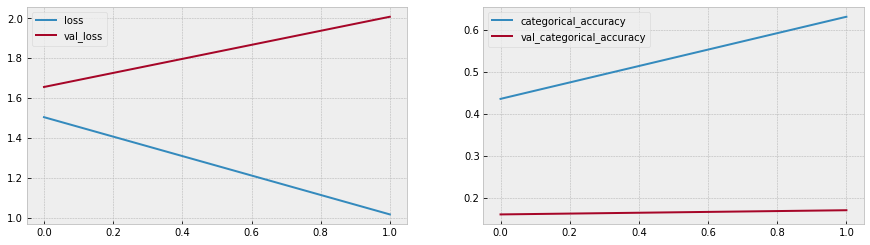

In [12]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=60,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

**Observation:** Batch size of 60 is too big as we get GPU error in colab. So lets try with batch size of 55.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_21 (Activation)  (None, 15, 60, 60, 32)   

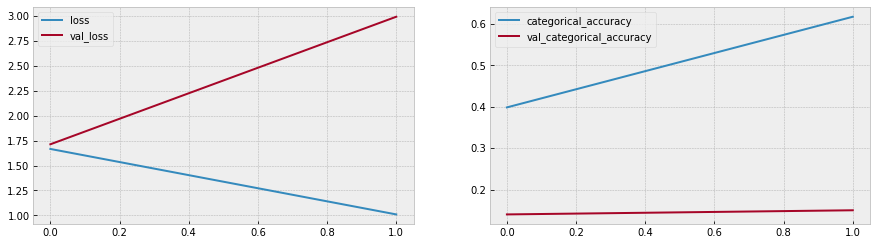

In [13]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=55,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

**Observation:** So batch size of 55 seems appropriate, so let's go ahead with building our model.

## Model 0

starting with an intital basic model

Parmas: image_height=120, image_width=120, frames_to_sample=30, batch_size=55, no_epochs=20

In [24]:
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=55,no_epochs=20)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_54 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_37 (Activation)  (None, 15, 60, 60, 32)   

In [25]:
%%time
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)

Epoch 1/20
12/13 [==========================>...] - ETA: 10s - loss: 1.6579 - categorical_accuracy: 0.4152
Epoch 00001: saving model to model_init_2023-10-2808_39_51.722631/model-00001-1.66361-0.41327-1.73979-0.24000.h5
13/13 [==============================] - 159s 13s/step - loss: 1.6636 - categorical_accuracy: 0.4133 - val_loss: 1.7398 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 1.0185 - categorical_accuracy: 0.5958 
Epoch 00002: saving model to model_init_2023-10-2808_39_51.722631/model-00002-1.01852-0.59578-2.34360-0.23000.h5
13/13 [==============================] - 149s 12s/step - loss: 1.0185 - categorical_accuracy: 0.5958 - val_loss: 2.3436 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.8988 - categorical_accuracy: 0.6591 
Epoch 00003: saving model to model_init_2023-10-2808_39_51.722631/model-00003-0.89885-0.65913-3.03876-0.18000.h5
13/1

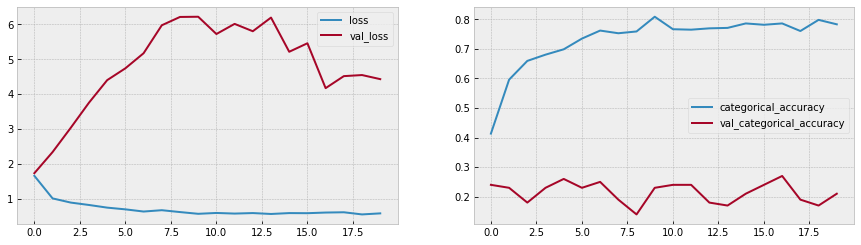

In [26]:
plot_model_history(history_conv_3d1_model)

**Observation:** We are getting a validation accuracy of 21.00% compared to tarining accuracy of 78.28%

- Total number of parameters are 900,805
- We are having low accuracy on valadation and it means its overfitting.
- Lets try **increasing** the number of parmas and see what happens.

## Model 1

In [5]:
class Model2(Init_modelBuilder_params):
    
    def model2(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Parmas:**

- image_height=120
- image_width=120
- frames_to_sample=30
- batch_size=55
- no_epochs=20

In [11]:
conv_3d2 = Model2()
conv_3d2.init_imageparams(image_height=120,image_width=120)
conv_3d2.init_hyperparams(frames_to_sample=30,batch_size=55,no_epochs=15)
conv_3d2_model = conv_3d2.model2(dense_neurons=256, dropout=0.5)
conv_3d2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 15, 60, 60, 32)    0

2023-10-28 12:48:13.847406: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-28 12:48:13.847488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [12]:
%%time
history_conv_3d2_model = conv_3d2.model_train(conv_3d2_model)

Epoch 1/15


2023-10-28 12:48:35.013990: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


13/13 [==============================] - ETA: 0s - loss: 1.8203 - categorical_accuracy: 0.3982 
Epoch 00001: saving model to model_init_2023-10-2812_48_00.186372/model-00001-1.82033-0.39819-1.46337-0.36000.h5
13/13 [==============================] - 154s 12s/step - loss: 1.8203 - categorical_accuracy: 0.3982 - val_loss: 1.4634 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 1.3368 - categorical_accuracy: 0.5324 
Epoch 00002: saving model to model_init_2023-10-2812_48_00.186372/model-00002-1.33680-0.53243-3.43392-0.19000.h5
13/13 [==============================] - 151s 13s/step - loss: 1.3368 - categorical_accuracy: 0.5324 - val_loss: 3.4339 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 1.0502 - categorical_accuracy: 0.6290 
Epoch 00003: saving model to model_init_2023-10-2812_48_00.186372/model-00003-1.05023-0.62896-5.71385-0.27000.h5
13/13 [========

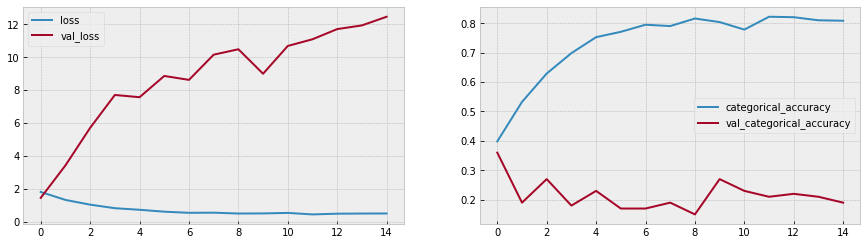

In [15]:
plot_model_history(history_conv_3d2_model)

**Observation:** We are getting a validation accuracy of 19.00% compared to tarining accuracy of 80.84%

- Total number of parameters are 1,967,813.
- We are still having low accuracy on valadation and the model is overfitting.
- Lets try using Dropout.

## Model 2

### Adding dropout layers

In [16]:
class Model2(Init_modelBuilder_params):
    
    def model2(self, filtersize=(3,3,3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Parmas:**

- image_height=120
- image_width=120
- frames_to_sample=30
- batch_size=50
- no_epochs=15
- dropout=0.5

In [17]:
conv_3d2 = Model2()
conv_3d2.init_imageparams(image_height=120,image_width=120)
conv_3d2.init_hyperparams(frames_to_sample=30,batch_size=50,no_epochs=15)
conv_3d2_model = conv_3d2.model2(dense_neurons=256, dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 15, 60, 60, 32)   

In [18]:
%%time
history_conv_3d2_model = conv_3d2.model_train(conv_3d2_model)

Epoch 1/15
14/14 [==============================] - ETA: 0s - loss: 1.9838 - categorical_accuracy: 0.3831
Epoch 00001: saving model to model_init_2023-10-2812_48_00.186372/model-00001-1.98384-0.38311-1.56222-0.29000.h5
14/14 [==============================] - 157s 12s/step - loss: 1.9838 - categorical_accuracy: 0.3831 - val_loss: 1.5622 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/15
14/14 [==============================] - ETA: 0s - loss: 1.3496 - categorical_accuracy: 0.5490
Epoch 00002: saving model to model_init_2023-10-2812_48_00.186372/model-00002-1.34961-0.54902-1.98100-0.25000.h5
14/14 [==============================] - 153s 12s/step - loss: 1.3496 - categorical_accuracy: 0.5490 - val_loss: 1.9810 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
14/14 [==============================] - ETA: 0s - loss: 1.0867 - categorical_accuracy: 0.6094
Epoch 00003: saving model to model_init_2023-10-2812_48_00.186372/model-00003-1.08674-0.60935-2.97157-0.22000.h5
14/14 [

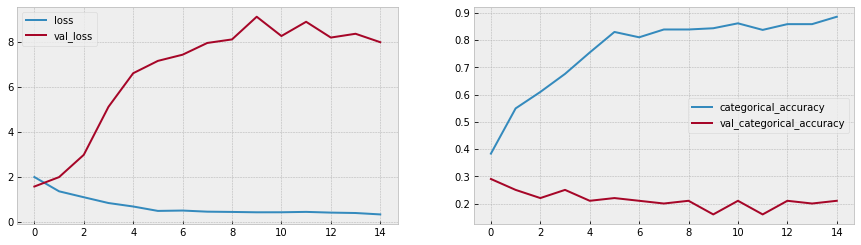

In [19]:
plot_model_history(history_conv_3d2_model)

**Observation**

- We are getting a validation accuracy of 21% compared to tarining accuracy of 88.54%

- Total number of trainable parameters are 1,967,813

- There is nothing much change in performance.

- Lets try changing the filter size and Frame.

See if it improves the model performace

## Model 3

Changing the filter to (2,2,2)

In [20]:
class Model2(Init_modelBuilder_params):
    
    def model2(self, filtersize=(2,2,2), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Parmas:**

- image_height=120
- image_width=120
- frames_to_sample=20
- batch_size=30
- no_epochs=25
- dropout=0.5

In [22]:
%%time
conv_3d5 = Model2()
conv_3d5.init_imageparams(image_height=120,image_width=120)
conv_3d5.init_hyperparams(frames_to_sample=20,batch_size=30,no_epochs=25)
conv_3d5_model = conv_3d5.model2(dense_neurons=256, dropout=0.5)
conv_3d5_model.summary()
history_conv_3d5_model = conv_3d5.model_train(conv_3d5_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 16)  400       
                                                                 
 activation_8 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 10, 60, 60, 32)   

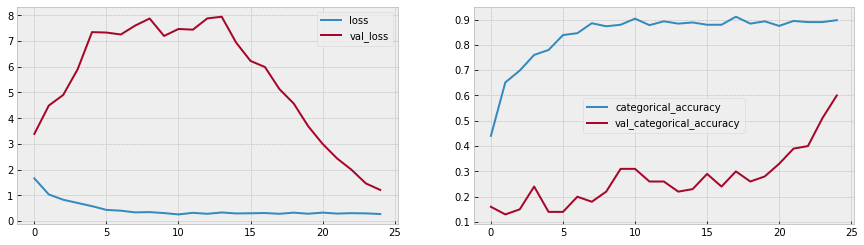

In [23]:
plot_model_history(history_conv_3d5_model)

**Observation**

- We are getting a validation accuracy of 60% compared to tarining accuracy of 89.74%
- Total number of trainable parameters are 1,761,109.
- So by reducing the initial filter size we can see that the number of parameters have gone down.
- We also observe a good increase in model's overall accuracy.

Lets try **adding more layers** to see how the model performace affected

## Model 4

Addition of Layers

In [24]:
class ModelConv3D2(Init_modelBuilder_params):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
    
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 20, 120, 120, 16)  6928      
                                                                 
 activation_13 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_19 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                     

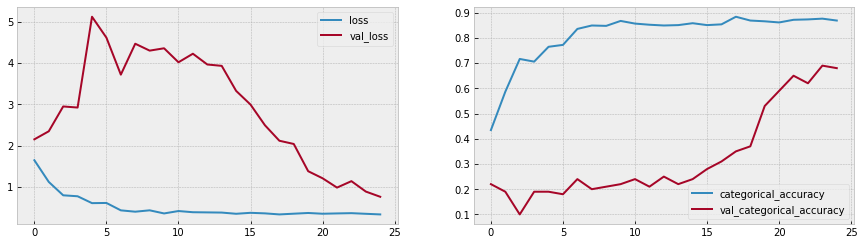

In [25]:
%%time
conv_3d4 = ModelConv3D2()
conv_3d4.init_imageparams(image_height=120,image_width=120)
conv_3d4.init_hyperparams(frames_to_sample=20,batch_size=30,no_epochs=25)
conv_3d4_model = conv_3d4.model_det(filter_size=(3,3,3),dense_neurons=256,drop_out=0.25)
conv_3d4_model.summary()
history_conv_3d4_model = conv_3d4.model_train(conv_3d4_model)
plot_model_history(history_conv_3d4_model)

**Observation**

- We are getting a validation accuracy of 68% compared to tarining accuracy of 86.88%
- Total number of trainable parameters are 2,554,549.
- So by adding more layers we can see that the number of parameters have increased a lot
- We also observe that the model's overall accuracy has increased.

Lets try dropping some connections to see if it improves the model performace.

## Model 5

Adding dropout at convolution layers

In [8]:
class ModelConv3D3(Init_modelBuilder_params):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out)) # here
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
    
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_28 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_21 (Conv3D)          (None, 20, 120, 120, 16)  6928      
                                                                 
 activation_21 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_29 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                     

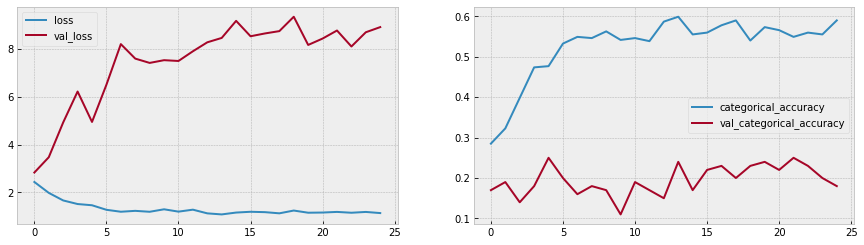

In [27]:
%%time
conv_3d5 = ModelConv3D3()
conv_3d5.init_imageparams(image_height=120,image_width=120)
conv_3d5.init_hyperparams(frames_to_sample=20,batch_size=30,no_epochs=25)
conv_3d5_model = conv_3d5.model_det(filter_size=(3,3,3),dense_neurons=256,drop_out=0.5)
conv_3d5_model.summary()
history_conv_3d5_model = conv_3d5.model_train(conv_3d5_model)
plot_model_history(history_conv_3d5_model)

**Observation**

- We are getting a validation accuracy of 18% compared to tarining accuracy of 58.97%
- Total number of trainable parameters are 2,554,549.
- Here we observe a significant drop in model performace

Issue could be dropout layers... We kept as 50% which could be too high and will see to keep it as 25%. Dropout=0.25

## Model 5.1:

Reducing the dropout to 25%

2023-10-29 05:59:55.579875: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-29 05:59:55.579945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 20, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                        

2023-10-29 06:00:01.953815: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.6512 - categorical_accuracy: 0.4208
Epoch 00001: saving model to model_init_2023-10-2905_57_19.509693/model-00001-1.65115-0.42081-2.59487-0.19000.h5
23/23 [==============================] - 115s 5s/step - loss: 1.6512 - categorical_accuracy: 0.4208 - val_loss: 2.5949 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.2115 - categorical_accuracy: 0.5566
Epoch 00002: saving model to model_init_2023-10-2905_57_19.509693/model-00002-1.21146-0.55656-4.64843-0.19000.h5
23/23 [==============================] - 109s 5s/step - loss: 1.2115 - categorical_accuracy: 0.5566 - val_loss: 4.6484 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.4410 - categorical_accuracy: 0.4751
Epoch 00003: saving model to model_init_2023-10-2905_57_19.509693/model-00003-1.44095-0.47511-5.44183-0.21000.h5
23/23 [=============

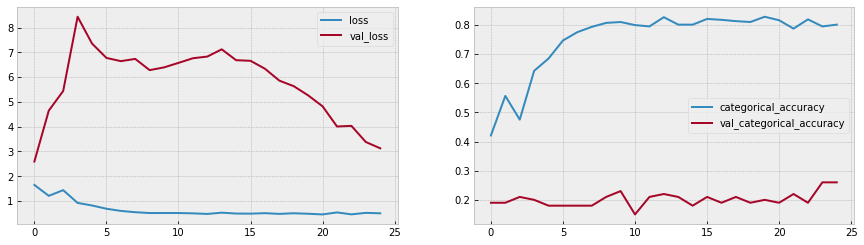

In [9]:
%%time
conv_3d5 = ModelConv3D3()
conv_3d5.init_imageparams(image_height=120,image_width=120)
conv_3d5.init_hyperparams(frames_to_sample=20,batch_size=30,no_epochs=25)
conv_3d5_model = conv_3d5.model_det(filter_size=(3,3,3),dense_neurons=256,drop_out=0.25)
conv_3d5_model.summary()
history_conv_3d5_model = conv_3d5.model_train(conv_3d5_model)
plot_model_history(history_conv_3d5_model)

**Observation**

- We are getting a validation accuracy of 26% compared to tarining accuracy of 80.09%
- Total number of trainable parameters are 2,554,549.
- Here we observe a significant improve in training accuracy and but same validation accuracy.
- Reason can be overfitting.


Issue could be the large number of parameters and the number of layers adding to the complexity. So we want to reduce the number of params now.

## Model 6

All experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance.

In [10]:
class ModelConv3D4(Init_modelBuilder_params):
    
    def model_det(self,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Parmas:

- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=20
- no_epochs=20
- dropout=0.25
- dense_neurons=128

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 32)    

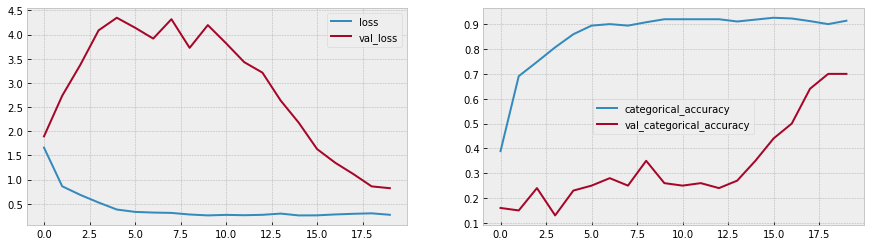

In [11]:
%%time
conv_3d6 = ModelConv3D4()
conv_3d6.init_imageparams(image_height=120,image_width=120)
conv_3d6.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=20)
conv_3d6_model = conv_3d6.model_det(dense_neurons=128,drop_out=0.25)
conv_3d6_model.summary()
history_conv_3d6_model = conv_3d6.model_train(conv_3d6_model)
plot_model_history(history_conv_3d6_model)

**Observation**

- We are getting a validation accuracy of 70% compared to tarining accuracy of 91.40%
- Total number of trainable parameters are 908,645 which is almost half of our last model.
- Here we observe a major increase in model performance but it’s **clearly overfitting**.

Lets see if we can get a better result by futher reducing the number of parameters

## Model 7

Reducing the number of parameters again

In [12]:
class ModelConv3D4(Init_modelBuilder_params):
    
    def model_det(self,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

**Parmas:**

- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=20
- no_epochs=20m
- dropout=0.25
- dense_neurons=64

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 8, 60, 60, 32)    

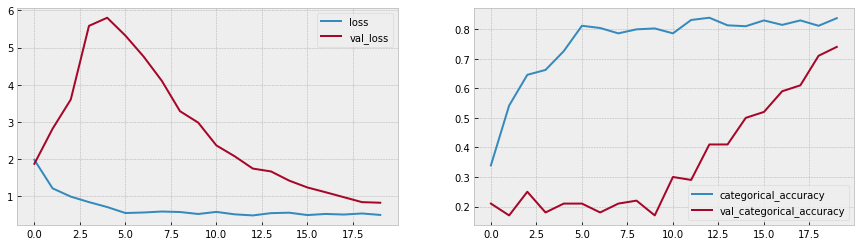

In [15]:
%%time
conv_3d7 = ModelConv3D4()
conv_3d7.init_imageparams(image_height=120,image_width=120)
conv_3d7.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=20)
conv_3d7_model = conv_3d7.model_det(dense_neurons=64,drop_out=0.25)
conv_3d7_model.summary()
history_conv_3d7_model = conv_3d7.model_train(conv_3d7_model)
plot_model_history(history_conv_3d7_model)

**Observation**

- We are getting a validation accuracy of 74% compared to tarining accuracy of 83.71%
- Total number of parameters are 494,981 which is almost half of our last model.
- We can see the model is performing well but accuracy is still low.
- Even from model 0-6 all are overfitting

Lets move ahead and try a CNN (2D conv) + RNN (LSTM) model.

## Model 8
CNN- LSTM Model

In [7]:
class RNNLstm(Init_modelBuilder_params):
    
    def model_det(self,lstm_cells=64,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation = 'relu'),
                                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
                  
        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                        
        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
                        
        model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                          
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(lstm_cells))
        model.add(Dropout(drop_out))
                  
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
                  
        model.add(Dense(self.num_classes,activation='softmax'))
                  
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

**Parmas:**

- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=20
- no_epochs=25
- dropout=0.25
- dense_neurons=128
- lstm_cells=128

2023-10-29 10:54:07.987488: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-29 10:54:07.987572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 60, 60, 32)   1

2023-10-29 10:54:13.916702: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.4423 - categorical_accuracy: 0.3590
Epoch 00001: saving model to model_init_2023-10-2910_51_34.451565/model-00001-1.44233-0.35897-1.64407-0.30000.h5
34/34 [==============================] - 95s 3s/step - loss: 1.4423 - categorical_accuracy: 0.3590 - val_loss: 1.6441 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1642 - categorical_accuracy: 0.5264
Epoch 00002: saving model to model_init_2023-10-2910_51_34.451565/model-00002-1.16416-0.52640-2.00072-0.22000.h5
34/34 [==============================] - 90s 3s/step - loss: 1.1642 - categorical_accuracy: 0.5264 - val_loss: 2.0007 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0799 - categorical_accuracy: 0.5475
Epoch 00003: saving model to model_init_2023-10-2910_51_34.451565/model-00003-1.07991-0.54751-1.82332-0.31000.h5
34/34 [===============

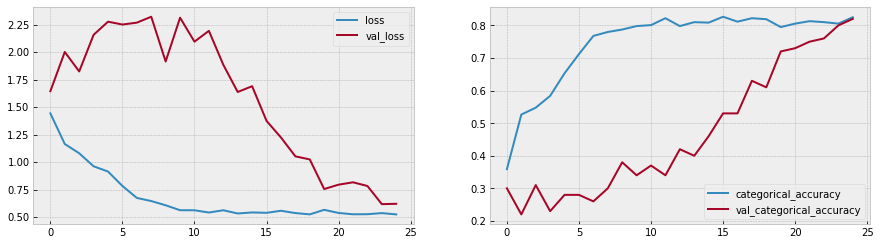

In [8]:
%%time
lstm_1 = RNNLstm()
lstm_1.init_imageparams(image_height=120,image_width=120)
lstm_1.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
lstm_1_model = lstm_1.model_det(lstm_cells=128,dense_neurons=128,drop_out=0.25)
lstm_1_model.summary()
history_lstm_1_model = lstm_1.model_train(lstm_1_model)
plot_model_history(history_lstm_1_model)

**Observation**

- We are getting a validation accuracy of 82% compared to tarining accuracy of 82.50%
- Total number of trainable parameters are 1,656,453.
- We can see with LSTM, we are getting good accuracy.

Lets try with **GRU**.

## Model 8.1

CNN- GRU Model

In [9]:
class RNN_GRU(Init_modelBuilder_params):
    
    def model_det(self,GRU_cells=64,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation = 'relu'),
                                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
                  
        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                        
        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
                        
        model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                          
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(GRU_cells))
        model.add(Dropout(drop_out))
                  
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
                  
        model.add(Dense(self.num_classes,activation='softmax'))
                  
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 60, 60, 32)  

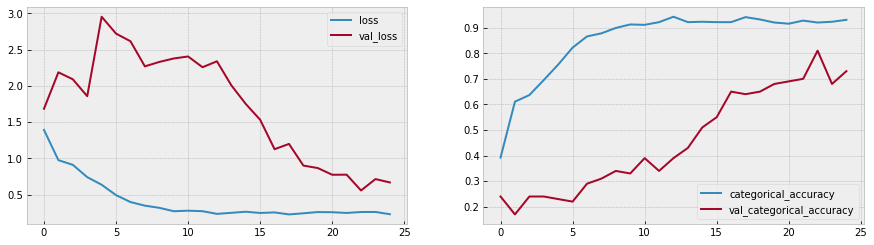

In [10]:
%%time
GRU_1 = RNN_GRU()
GRU_1.init_imageparams(image_height=120,image_width=120)
GRU_1.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
GRU_1_model = GRU_1.model_det(GRU_cells=128,dense_neurons=128,drop_out=0.25)
GRU_1_model.summary()
history_GRU_1_model = GRU_1.model_train(GRU_1_model)
plot_model_history(history_GRU_1_model)

**Observation**

- We are getting a validation accuracy of 73% compared to tarining accuracy of 93.06%
- Total number of trainable parameters are 1,346,405
- LSTM was performing much better than GRU.

### Lets see if we can improve it futher by using **data augmentaion techniques**

### Let's apply some data augmentation & check the model performance.

In [7]:
class Model_params_Augmentdata():
    
    def init_imageparams(self,image_height=100,image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
        
    def init_hyperparams(self,frames_to_sample=30,batch_size=20,no_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.no_epochs = no_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
#         print( 'Source path = ', source_path, '; batch size =', batch_size)
        
        #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
            
            for batch in range(num_batches):
                batch_data, batch_labels = self.generator_extended(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels
                
            balance_len = len(t)%batch_size
            
            if (balance_len !=0):
                batch_data, batch_labels = self.generator_extended(source_path,t,batch,batch_size,img_idx,augment,balance_len)
                yield batch_data, batch_labels
                
    
    def generator_extended(self,source_path,t,batch,batch_size,img_idx,augment,balance_len=0):
        
        len_seq = balance_len if (balance_len!=0) else batch_size
        
        batch_data = np.zeros((len_seq,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_data = np.zeros((len_seq,len(img_idx),self.image_height,self.image_width,self.channels))
        # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((len_seq,5))
        # batch_labels is the one hot representation of the output
        if (augment): batch_data_aug = np.zeros((len_seq,len(img_idx),self.image_height,self.image_width,self.channels))
        
        for folder in range(len_seq): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resize = resize(image,(self.image_height,self.image_width,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #normalise and feed in the image
                batch_data[folder,idx,:,:,0] = (image_resize[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resize[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resize[:,:,2])/255
                    
                if (augment):
                        
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
      
                    
                        
                    #normalise and feed in the image
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                        
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
        if (augment):
            
            batch_data = np.concatenate([batch_data,batch_data_aug])
            batch_labels = np.concatenate([batch_labels,batch_labels])
                
        return(batch_data, batch_labels)
    
        
    def model_train(self ,model,augment_data=False):
        
        train_generator = self.generator(train_path, train_doc,augment= augment_data)
        val_generator = self.generator(val_path, val_doc)

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        # write the REducelronplateau code here
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%self.batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1


        temp_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.no_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
        return temp_model

## Model 9

Adding data augmentation.

In [12]:
class ModelConv3D_Aug1(Model_params_Augmentdata):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

**Parmas:**

- image_height=120
- image_width=120
- frames_to_sample=20
- batch_size=20
- no_epochs=25
- dropout=0.5
- dense_neurons=256

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 32)   

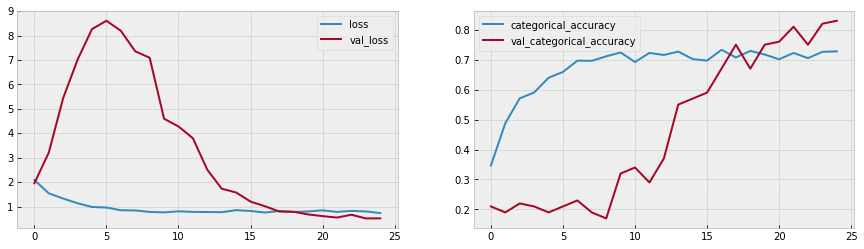

In [13]:
%%time
conv_3d_aug1 = ModelConv3D_Aug1()
conv_3d_aug1.init_imageparams(image_height=120,image_width=120)
conv_3d_aug1.init_hyperparams(frames_to_sample=20,batch_size=20,no_epochs=25)
conv_3d_aug1_model = conv_3d_aug1.model_det(dense_neurons=256,drop_out=0.5)
conv_3d_aug1_model.summary()
history_conv_3d_aug1_model = conv_3d_aug1.model_train(conv_3d_aug1_model,augment_data=True)
plot_model_history(history_conv_3d_aug1_model)

**Observation**

- We are getting a validation accuracy of 83% compared to tarining accuracy of 72.78%
- Total number of trainable parameters are 1,966,309.
- We see that the validation accuracy has improved alot and the training accuracy has dropped slightly compare to model 0.

Lets see if we can improve the model with some basic simplifications

## Model 10

Increasing batch size and decreasing filter size Parmas:

**Params:**

- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=30
- no_epochs=25
- dropout=0.5
- dense_neurons=256
- filter_size=(2,2,2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  400       
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

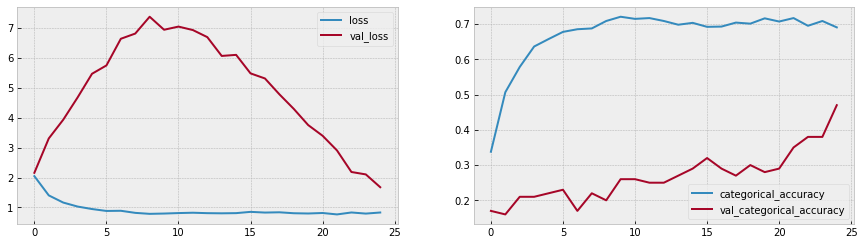

In [14]:
%%time
conv_3d_aug1 = ModelConv3D_Aug1()
conv_3d_aug1.init_imageparams(image_height=120,image_width=120)
conv_3d_aug1.init_hyperparams(frames_to_sample=16,batch_size=30,no_epochs=25)
conv_3d_aug1_model = conv_3d_aug1.model_det(filter_size=(2,2,2),dense_neurons=256,drop_out=0.5)
conv_3d_aug1_model.summary()
history_conv_3d_aug1_model = conv_3d_aug1.model_train(conv_3d_aug1_model,augment_data=True)
plot_model_history(history_conv_3d_aug1_model)

**Observation**

- We are getting a validation accuracy of 47% compared to tarining accuracy of 69.08%
- Total number of trainable parameters are 1,761,109. Reduced slightly from previous model.
- We see that both the validation accuracy and the training accuracy have shown **decreased**.

Lets see the impact of **adding more layers** to our present model.

## Model 11

Adding more layers

In [8]:
class ModelConv3D_Aug2(Model_params_Augmentdata):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

**Parmas:**

- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=20
- no_epochs=25
- dropout=0.5
- dense_neurons=256

2023-10-29 14:59:17.634410: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-29 14:59:17.634493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                        

2023-10-29 14:59:24.146950: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 2.1270 - categorical_accuracy: 0.3296
Epoch 00001: saving model to model_init_2023-10-2914_58_18.392569/model-00001-2.12702-0.32956-1.93720-0.13000.h5
34/34 [==============================] - 163s 5s/step - loss: 2.1270 - categorical_accuracy: 0.3296 - val_loss: 1.9372 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6320 - categorical_accuracy: 0.4517
Epoch 00002: saving model to model_init_2023-10-2914_58_18.392569/model-00002-1.63199-0.45173-2.80136-0.16000.h5
34/34 [==============================] - 154s 5s/step - loss: 1.6320 - categorical_accuracy: 0.4517 - val_loss: 2.8014 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3686 - categorical_accuracy: 0.5166
Epoch 00003: saving model to model_init_2023-10-2914_58_18.392569/model-00003-1.36856-0.51659-3.78628-0.26000.h5
34/34 [=====

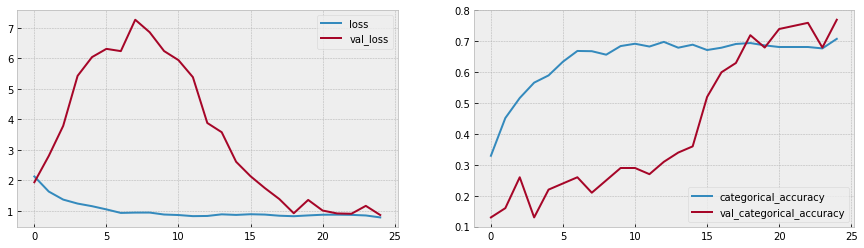

In [9]:
%%time
conv_3d_aug2 = ModelConv3D_Aug2()
conv_3d_aug2.init_imageparams(image_height=120,image_width=120)
conv_3d_aug2.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
conv_3d_aug2_model = conv_3d_aug2.model_det(dense_neurons=256,drop_out=0.5)
conv_3d_aug2_model.summary()
history_conv_3d_aug2_model = conv_3d_aug2.model_train(conv_3d_aug2_model,augment_data=True)
plot_model_history(history_conv_3d_aug2_model)

**Observation**

- We are getting a validation accuracy of 77% compared to tarining accuracy of 70.81%
- Total number of trainable parameters are 2,554,549. Major increase from previous model
- We see that both the validation accuracy and the training accuracy have shown improvement.

Lets see if reducing number of trainable params with dropout helps improving the model or not.

## Model 12

Adding dropouts

In [8]:
class ModelConv3D_Aug2(Model_params_Augmentdata):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

2023-10-30 03:21:37.041948: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-30 03:21:37.042042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                        

2023-10-30 03:21:44.839342: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.7828 - categorical_accuracy: 0.3605
Epoch 00001: saving model to model_init_2023-10-3003_19_31.612052/model-00001-1.78278-0.36048-2.80958-0.16000.h5
34/34 [==============================] - 199s 6s/step - loss: 1.7828 - categorical_accuracy: 0.3605 - val_loss: 2.8096 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4545 - categorical_accuracy: 0.4434
Epoch 00002: saving model to model_init_2023-10-3003_19_31.612052/model-00002-1.45449-0.44344-3.41938-0.22000.h5
34/34 [==============================] - 173s 5s/step - loss: 1.4545 - categorical_accuracy: 0.4434 - val_loss: 3.4194 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1921 - categorical_accuracy: 0.5407
Epoch 00003: saving model to model_init_2023-10-3003_19_31.612052/model-00003-1.19208-0.54072-5.85588-0.27000.h5
34/34 [=============

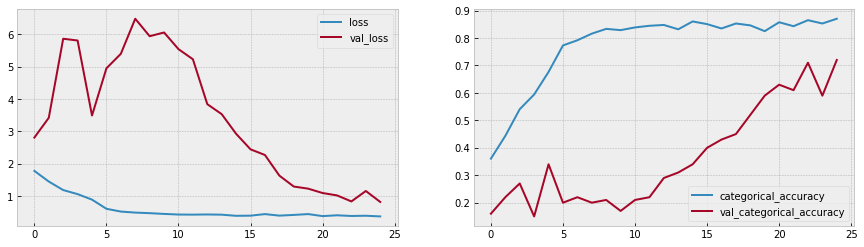

In [9]:
%%time
conv_3d_aug2 = ModelConv3D_Aug2()
conv_3d_aug2.init_imageparams(image_height=120,image_width=120)
conv_3d_aug2.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
conv_3d_aug2_model = conv_3d_aug2.model_det(dense_neurons=256,drop_out=0.25)
conv_3d_aug2_model.summary()
history_conv_3d_aug2_model = conv_3d_aug2.model_train(conv_3d_aug2_model,augment_data=True)
plot_model_history(history_conv_3d_aug2_model)

**Observation**

- We are getting a validation accuracy of 72% compared to tarining accuracy of 87.03%
- Total number of trainable parameters are 2,554,549.
- We see that both the validation accuracy has decresed but the training accuracy have shown improvement. But its overfitting.

Lets see if reducing number of network params helps improving the model or not.

## Model 13

Reducing network parameters

In [8]:
class ModelConv3D_Aug3(Model_params_Augmentdata):
    
    def model_det(self,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [11]:
%%time
conv_3d_aug3 = ModelConv3D_Aug3()
conv_3d_aug3.init_imageparams(image_height=120,image_width=120)
conv_3d_aug3.init_hyperparams(frames_to_sample=30,batch_size=20,no_epochs=25)
conv_3d_aug3_model = conv_3d_aug3.model_det(dense_neurons=128,drop_out=0.25)
conv_3d_aug3_model.summary()
history_conv_3d_aug3_model = conv_3d_aug3.model_train(conv_3d_aug3_model,augment_data=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 15, 60, 60, 32)   

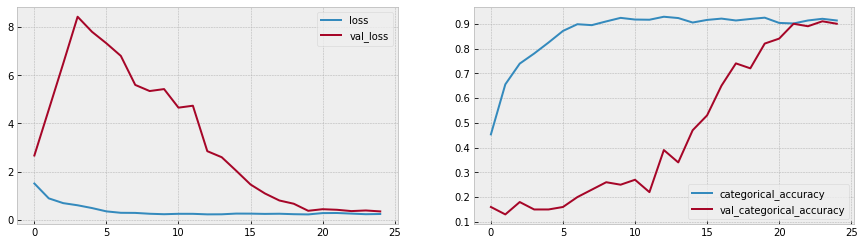

In [12]:
plot_model_history(history_conv_3d_aug3_model)

**Observation**

- We are getting a validation accuracy of 90% compared to tarining accuracy of 91.33%
- Total number of trainable parameters are 908,645. Which is quite less than before.
- We see huge improvement in both the validation accuracy and the training accuracy.

lets try to decrease the frame number to 16, and set epoch to 30 and see.

## Model 13.1

In [9]:
class ModelConv3D_Aug3(Model_params_Augmentdata):
    
    def model_det(self,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

2023-10-30 07:22:51.884779: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-30 07:22:51.884843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Epoch 1/30


2023-10-30 07:22:58.049516: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.4658 - categorical_accuracy: 0.4465
Epoch 00001: saving model to model_init_2023-10-3007_21_51.094998/model-00001-1.46585-0.44646-4.20077-0.16000.h5
34/34 [==============================] - 162s 5s/step - loss: 1.4658 - categorical_accuracy: 0.4465 - val_loss: 4.2008 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0274 - categorical_accuracy: 0.6011
Epoch 00002: saving model to model_init_2023-10-3007_21_51.094998/model-00002-1.02742-0.60106-7.13394-0.15000.h5
34/34 [==============================] - 157s 5s/step - loss: 1.0274 - categorical_accuracy: 0.6011 - val_loss: 7.1339 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.8045 - categorical_accuracy: 0.6878
Epoch 00003: saving model to model_init_2023-10-3007_21_51.094998/model-00003-0.80449-0.68778-9.71325-0.12000.h5
34/34 [=============

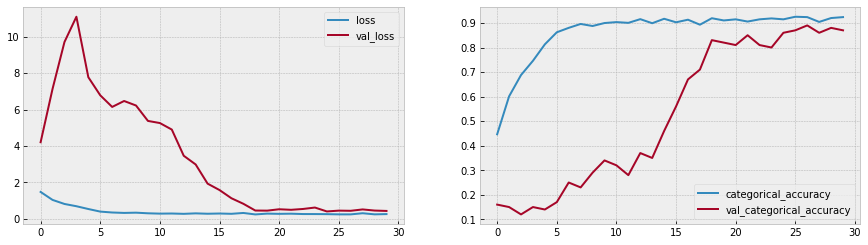

In [10]:
%%time
conv_3d_aug3 = ModelConv3D_Aug3()
conv_3d_aug3.init_imageparams(image_height=120,image_width=120)
conv_3d_aug3.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=30)
conv_3d_aug3_model = conv_3d_aug3.model_det(dense_neurons=128,drop_out=0.25)
conv_3d_aug3_model.summary()
history_conv_3d_aug3_model = conv_3d_aug3.model_train(conv_3d_aug3_model,augment_data=True)

plot_model_history(history_conv_3d_aug3_model)

**Observation**

- We are getting a validation accuracy of 92.38% compared to tarining accuracy of 89%
- Total number of trainable parameters are 908,645.
- We see that both the validation accuracy and the training accuracy have shown huge improvement and we have solved the overfitting.
- And as of now this is the best model from model 0 - 13.1

Epoch 27/30
34/34 [==============================] - ETA: 0s - loss: 0.2320 - categorical_accuracy: 0.9238
Epoch 00027: saving model to model_init_2023-10-3007_21_51.094998/model-00027-0.23201-0.92383-0.42889-0.89000.h5
34/34 [==============================] - 168s 5s/step - loss: 0.2320 - **categorical_accuracy: 0.9238** - val_loss: 0.4289 - **val_categorical_accuracy: 0.8900** - lr: 1.0000e-06

- Lets try a different model like CNN (2D) + RNN (GRU) next

## Model 14

CNN with GRU

In [11]:
class RNNCNN2(Model_params_Augmentdata):
    
    def model_det(self, GRU_cells=64, dense_neurons=64, drop_out=0.25):
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3,3), padding = 'same', activation= 'relu'),
                                 input_shape = (self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Conv2D(32, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Conv2D(64, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        
        model.add(TimeDistributed(Conv2D(128, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(GRU_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [12]:
%%time
gru_2 = RNNCNN2()
gru_2.init_imageparams(image_height=120,image_width=120)
gru_2.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
gru_2_model = gru_2.model_det(GRU_cells=128, dense_neurons=128, drop_out=0.25)
gru_2_model.summary()
history_gru_2_model = gru_2.model_train(gru_2_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 60, 60, 32)  

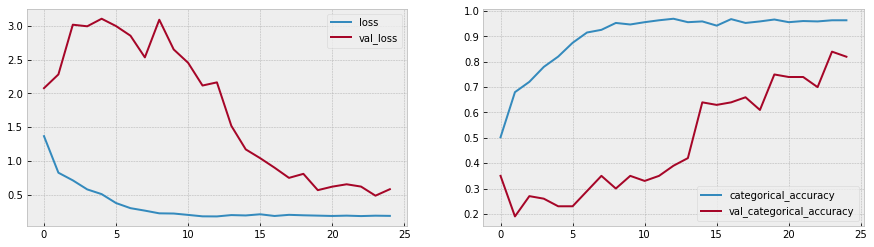

In [13]:
plot_model_history(history_gru_2_model)

**Observation:**

- We are getting a validation accuracy of 82.00% compared to tarining accuracy of 96.38%
- Total number of parameters are 2,557,413.
- We can clearly see its **overfitting**.

Now lets try **LSTM**.

## Model 15

CNN with LSTM

In [14]:
class RNNCNN2(Model_params_Augmentdata):
    
    def model_det(self, LSTM_cells=64, dense_neurons=64, drop_out=0.25):
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3,3), padding = 'same', activation= 'relu'),
                                 input_shape = (self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Conv2D(32, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Conv2D(64, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        
        model.add(TimeDistributed(Conv2D(128, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(LSTM_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [15]:
%%time
lstm_2 = RNNCNN2()
lstm_2.init_imageparams(image_height=120,image_width=120)
lstm_2.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
lstm_2_model = lstm_2.model_det(LSTM_cells=128, dense_neurons=128, drop_out=0.25)
lstm_2_model.summary()
history_lstm_2_model = lstm_2.model_train(lstm_2_model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 16, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 60, 60, 32)  

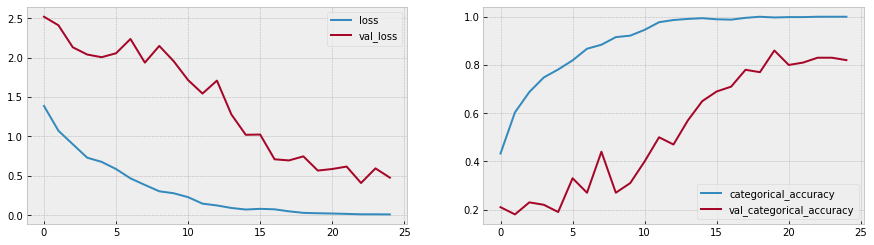

In [16]:
plot_model_history(history_lstm_2_model)

**Observation:**

- We are getting a validation accuracy of 82.00% compared to tarining accuracy of 100%
- Total number of parameters are 3,376,357.
- We can clearly see it's **overfitting**.


Now lets try **Transfer Learning**.

## Let us bring in Transfer Learning

## Model 16

with **LSTM**.

In [8]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. 

from tensorflow.keras.applications import MobileNet
transfer_learning = MobileNet(weights = 'imagenet', include_top = False)

2023-10-31 03:38:09.769843: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-31 03:38:09.769908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


17235968/17225924 [==============================] - 2s 0us/step


In [9]:
class RNN_CNN_TL1(Model_params_Augmentdata):
    
    def model_det(self,lstm_cells=64, dense_neurons=64, drop_out=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(transfer_learning,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(2,2)))
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(lstm_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                2

2023-10-31 03:40:35.218566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.4964 - categorical_accuracy: 0.3575
Epoch 00001: saving model to model_init_2023-10-3103_35_15.839158/model-00001-1.49636-0.35747-1.22644-0.56000.h5
67/67 [==============================] - 90s 1s/step - loss: 1.4964 - categorical_accuracy: 0.3575 - val_loss: 1.2264 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0059 - categorical_accuracy: 0.6169
Epoch 00002: saving model to model_init_2023-10-3103_35_15.839158/model-00002-1.00590-0.61689-0.90689-0.69000.h5
67/67 [==============================] - 83s 1s/step - loss: 1.0059 - categorical_accuracy: 0.6169 - val_loss: 0.9069 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7028 - categorical_accuracy: 0.7722
Epoch 00003: saving model to model_init_2023-10-3103_35_15.839158/model-00003-0.70280-0.77225-0.82610-0.71000.h5
67/67 [===============

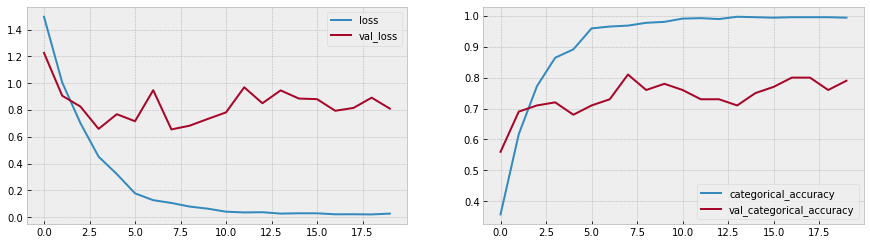

In [10]:
%%time
tranf_learning = RNN_CNN_TL1()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16,batch_size=10,no_epochs=20)
tranf_learning_model = tranf_learning.model_det(lstm_cells=64, dense_neurons=64, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model = tranf_learning.model_train(tranf_learning_model)

plot_model_history(history_tranf_learning_model)

**Observation:**

- We are getting a validation accuracy of 79.00% compared to tarining accuracy of 99.4%
- Total number of parameters are 3,516,229.
- We can clearly see its **overfitting**.

lets try with **GRU**.

## Model 17

Transfer Learning with GRU and training all weights.

In [11]:
transfer_learning2 = MobileNet(weights = 'imagenet', include_top = False)

class RNN_CNN_TL2(Model_params_Augmentdata):
    
    def model_det(self,gru_cells =64,dense_neurons= 64, drop_out=0.25):
        model = Sequential()
        model.add(TimeDistributed(transfer_learning,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(2,2)))
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
%%time
tranf_learning = RNN_CNN_TL2()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16, batch_size=10, no_epochs=20)

tranf_learning_model = tranf_learning.model_det(gru_cells=128, dense_neurons=128, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model1 = tranf_learning.model_train(tranf_learning_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

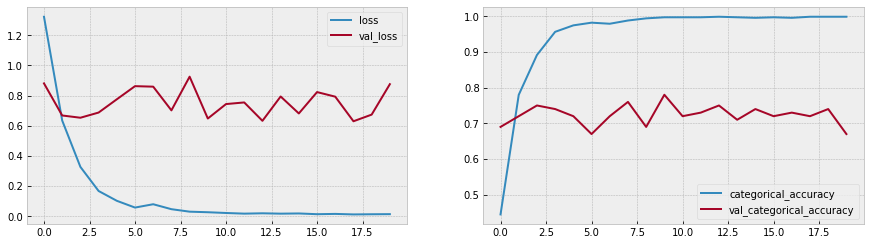

In [13]:
plot_model_history(history_tranf_learning_model1)

**Observation:** 

- We are getting a validation accuracy of 67.00% compared to tarining accuracy of 99.85%
- Total number of parameters are 3,693,253.
- We can clearly see its **overfitting**.

lets try GRU with cells=64 and dense=64

## Model 18:

Transfer Learning with GRU with cell=64 and dense=64.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 64)               

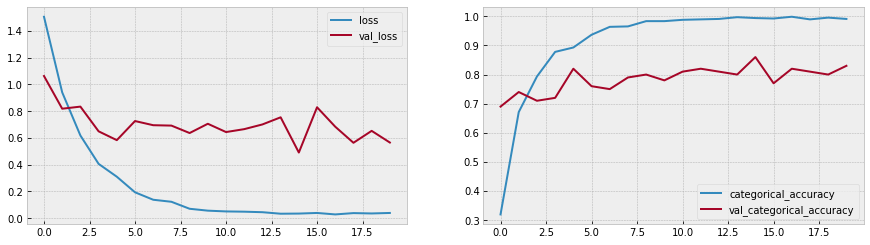

In [14]:
%%time
tranf_learning = RNN_CNN_TL2()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16,batch_size=10,no_epochs=20)
tranf_learning_model = tranf_learning.model_det(gru_cells=64, dense_neurons=64, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model2 = tranf_learning.model_train(tranf_learning_model)
plot_model_history(history_tranf_learning_model2)

**Observation:** 

- We are getting a validation accuracy of 83.00% compared to tarining accuracy of 99.10%
- Total number of parameters are 3,446,725.
- We can clearly see its **overfitting** again.

So, we dont see much improvement with redusing dense and number of cell.
Lets try to applying it **without augmentation**.

## Model 19:

Without augmentation

In [15]:
transfer_learning2 = MobileNet(weights = 'imagenet', include_top = False)

class RNN_CNN_TL3(Init_modelBuilder_params):
    
    def model_det(self,gru_cells =64,dense_neurons= 64, drop_out=0.25):
        model = Sequential()
        model.add(TimeDistributed(transfer_learning,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(2,2)))
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
%%time
tranf_learning = RNN_CNN_TL3()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16, batch_size=10, no_epochs=20)

tranf_learning_model = tranf_learning.model_det(gru_cells=64, dense_neurons=64, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model1 = tranf_learning.model_train(tranf_learning_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 64)               

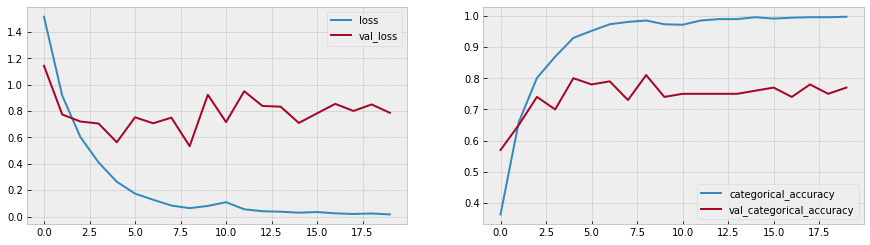

In [17]:
plot_model_history(history_tranf_learning_model1)

**Observation:**

- We are getting a validation accuracy of 77.00% compared to tarining accuracy of 99.70%
- Total number of parameters are 3,446,725.
- We can clearly see its **overfitting** again.

So, we dont see much improvement with reducing dense and number of cell.
Lets apply **EfficientNetB2**.

## Model 20: Using EfficientNetB2

gru_cells=64, 
dense_neurons=64

In [18]:
from tensorflow.keras.applications import EfficientNetB2

In [19]:
transfer_learning_model = EfficientNetB2(weights = 'imagenet', include_top = False)

31801344/31790344 [==============================] - 3s 0us/step


In [20]:
class RNN_CNN_TL2(Model_params_Augmentdata):
    
    def model_det(self, gru_cells=64, dense_neurons= 64, drop_out=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(transfer_learning_model, input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(2,2)))
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 3, 3, 1408)   7768569   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 3, 3, 1408)   5632      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 1, 1, 1408)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 1408)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 128)              

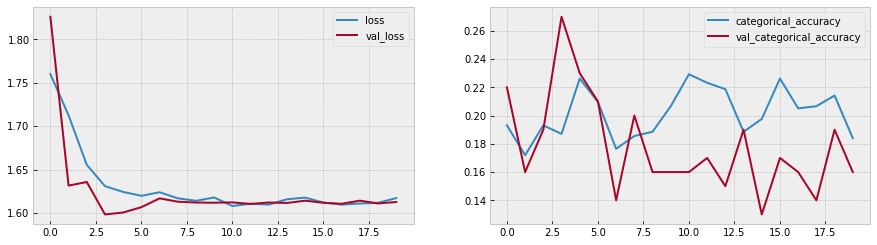

In [21]:
%%time
tranf_learning = RNN_CNN_TL2()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16,batch_size=10,no_epochs=20)
tranf_learning_model = tranf_learning.model_det(gru_cells=128, dense_neurons=128, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model = tranf_learning.model_train(tranf_learning_model)

plot_model_history(history_tranf_learning_model)

**Observation:**

- We are getting a validation accuracy of 16% compared to tarining accuracy of 18.40%
- Total number of parameters are 8,381,950.

We can clearly see this model is of no use. so we will end here.

## Here are all the models with their respective accuracy and number of parameters.

In [ ]:
| Model No.        | Model Type         | No. parameters | Categorical Accuracy (%) | Validation Categorical 
                                                                                             Accuracy (%) |
|------------------|-------------------|----------------|-------------------------|-----------------------|
| 0                | 3D CNN            | 900805         | 21                      | 78.28                 |
| 1                | 3D CNN            | 1967813        | 19                      | 80.84                 |
| 2                | 3D CNN            | 1967813        | 21                      | 88.54                 |
| 3                | 3D CNN            | 1762613        | 60                      | 89.74                 |
| 4                | 3D CNN            | 2556533        | 68                      | 86.88                 |
| 5                | 3D CNN            | 2556533        | 18                      | 58.97                 |
| 5.1              | 3D CNN            | 2556533        | 26                      | 80.09                 |
| 6                | 3D CNN            | 909637         | 70                      | 91.4                  |
| 7                | 3D CNN            | 494981         | 74                      | 83.71                 |
| 8                | CNN-LSTM          | 1657445        | 82                      | 82.5                  |
| 8.1              | CNN-GRU           | 1346405        | 73                      | 93.06                 |
|                  |                   |                |                         |                       |
| With Data Augmentation |             |                |                         |                       |
| 9                | 3D CNN            | 1967813        | 83                      | 72.78                 |
| 10               | 3D CNN            | 1762613        | 47                      | 69.08                 |
| 11               | 3D CNN            | 2556533        | 77                      | 70.81                 |
| 12               | 3D CNN            | 2556533        | 72                      | 87.03                 |
| 13               | 3D CNN            | 909637         | 90                      | 91.33                 |
| 13.1             | 3D CNN            | 909637         | 92.38                   | 89                    |
| 14               | CNN-GRU           | 2557413        | 82                      | 96.38                 |
| 15               | CNN-LSTM          | 3376357        | 82                      | 100                   |
| 16               | TL-LSTM(MobileNet)| 3516229        | 79                      | 99.4                  |
| 17               | TL-GRU(MobileNet) | 3693253        | 67                      | 99.85                 |
| 18               | TL-GRU(MobileNet) | 3446725        | 83                      | 99.1                  |
| 19               | TL-GRU-Non_AUG     | 3446725        | 77                      | 99.7                  |
| 20               | TL-GRU(EfficientNetB2) | 8381950  | 16                    | 18.4                  |


## So, here we have concluded that Model no 13.1 gave the best accuracy score both for Categorical(92.38%) and Validation Categorical (89%).